EPITA 2020 MLRF practice_01-04_color-histogram v2020-06-22_233547 by Joseph CHAZALON

<div style="overflow: auto; padding: 10px; margin: 10px 0px">
<img alt="Creative Commons License" src='img/CC-BY-4.0.png' style='float: left; margin-right: 20px'>
    
This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).
</div>

# Practice 1 part 4: (Indexed) color histograms as global descriptors

The principle is very simple and illustrated below: from a set of pixels we count how many times each color appears, and we build an histogram of the frequencies (as opposed to raw counts, because we normalize the values) of occurrences of colors.

Here are some examples of the histograms we can compute from some bubbles:
![hist1](img/hist1.png)
![hist2](img/hist2.png)
![hist3](img/hist3.png)

Using such descriptors, we can very easily group similar bubbles with a reasonable confidence.

This part contains the following steps:
1. Color quantization: reduce the colors of the bubbles.
2. Compute the color histogram of each bubble.
3. Compute the distance matrix between each bubble, using its color histogram.
4. Visualize the bubbles in an interesting way using hierarchical clustering.


## 1. Color quantization
It is hard to compare the full RGB histogram of an image (a bubble) with the histogram of another, so we will first **reduce the number of colors** used to represent each image.


Color quantization is a practical application of [vector quantization](https://en.wikipedia.org/wiki/Vector_quantization) where each color is replaced by the closest color in a pre-defined palette.


We have two options here:
1. build a palette manually
2. use a clustering technique to build it automatically

We will use **K-Means clustering** to discover a reduced set of representative colors.

<div style="overflow: auto; border-style: solid; border-color: red; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="stop" src='img/stop.png' style='float: left; margin-right: 20px'>
    
**If you do not manage to build the palette automatically, then build your codebook manually and convert the color of the images using [`scipy.cluster.vq.vq`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.vq.html).**
</div>

### 1.1. Sample some pixels
Because K-Means is a costly algorithm, we will first sample our pixels (viewing them as plain 3-dimensional vectors) to avoid filling up our memory during KMeans fitting.

We will use the base image to facilitate the sampling, because otherwise we would have to select pixels from every bubble image and merge the results.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use the large (200 DPI) poster image WITH ITS MASK to sample some pixels. 5000 is a good number of samples.**

*Tips:*
- The code for loading the image is provided below to save you time.
- `poster[poster_mask]` returns a set of valid pixels.
- You can use [`np.random.choice`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html#numpy.random.choice) to select **random indexes** and then use those indexes to select random pixels.
</div>

In [4]:
# deactivate buggy jupyter completion
%config Completer.use_jedi = False

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import os

In [6]:
# TODO
PATH_TO_RESOURCES = "twin_it"  # FIXME set this to the path of the twinit resource directory
#print(os.listdir())

In [59]:
# load the base image and its mask.
poster = cv2.imread(os.path.join(PATH_TO_RESOURCES, "twin_it_200dpi.png"))
# let us convert the poster from BGR to RGB for what follows
# we will work with RGB images
poster = cv2.cvtColor(poster, cv2.COLOR_BGR2RGB)
poster_mask = cv2.imread(os.path.join(PATH_TO_RESOURCES, "mask_bubbles.png"))[..., 0] > 0
#poster_mask = cv2.cvtColor(poster_mask, cv2.COLOR_BGR2RGB)
poster.shape, poster.dtype, poster_mask.shape, poster_mask.dtype

((5956, 4153, 3), dtype('uint8'), (5956, 4153), dtype('bool'))

<img alt="warning" src='img/warning.png' style='float: left; margin-right: 20px'>

**WARNING: All our images should be in RGB format in this session! Convert them when loading them to avoid mistakes.**

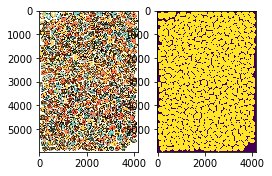

In [8]:
plt.subplot(1,3,1)
plt.imshow(poster) 
# no need for `cv2.cvtColor` because we already have an RGB image
plt.subplot(1,3,2)
plt.imshow(poster_mask)
#plt.subplot(1,3,3)
#plt.imshow(poster[poster_mask])


In [9]:
# TODO now sample 5000 pixels from the image
pmasked = poster[poster_mask]
sample_indices = np.random.choice(pmasked.shape[0], 5000, replace=False)
sample_pixels = pmasked[sample_indices]  # FIXME
# ...
sample_pixels.shape, sample_pixels.dtype
# The last line should return
# ((5000, 3), dtype('uint8'))
print(poster.shape, poster_mask.shape,pmasked.shape)
print(5956*4153)

(5956, 4153, 3) (5956, 4153) (20012105, 3)
24735268


### 1.2. K-Means clustering stage 1/2: fitting
We are now ready to perform K-Means clustering.

In [10]:
from sklearn.cluster import KMeans

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use K-Means clustering to compute the color palette. Use a small value like 7 for the number of target colors.**

Tip:
- Set the `random_state` parameter to some fixed value to ensure the reproducibility of your results.
- Use the `fit` method to compute cluster centers.
- The cluster centers will be available with `kmeans.cluster_centers_`.
</div>

<img alt="warning" src='img/warning.png' style='float: left; margin-right: 20px'>

**WARNING: K-Means is a RAM-hungry algorithm. Save your work regularly (and start now)!**

In [313]:
# TODO compute the new color palette
kmeans = KMeans(n_clusters=13, random_state=0).fit(sample_pixels) # FIXME


### 1.3. K-Means clustering stage 2/2: projection
The [`KMeans` class](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) provided by scikit-learn has two methods for transforming our data:
- `transform`
- `predict`

**Make sure you understand the difference between those two functions.**

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Use the `KMeans` object and super fancy Numpy indexing to create a new image where the color of each pixel is the color of the closest cluster to the original pixel color.**

Tip:
- Do not forget to mask the background of the image during prediction (because we did not train the predictor on them).
- Start by producing a new image with cluster labels instead of color values.
- Then create a color lookup table (LUT) using cluster centers (make sure to use `np.uint8` values to avoid issues with later conversion).
- Finally use Numpy advanced indexing to apply the LUT to the image with cluster labels.
</div>

In [314]:
# Some extra help about the LUT thing:
my_LUT = np.array([("a", "b"),  # "cluster" 0
                   ("c", "d")]) # "cluster" 1
my_label_image = np.array([[0,1,0,1,1]])
my_LUT[my_label_image]
# The result contains values from `my_LUT` and has the shape of `my_label_image`. Simply beautiful.

array([[['a', 'b'],
        ['c', 'd'],
        ['a', 'b'],
        ['c', 'd'],
        ['c', 'd']]], dtype='<U1')

In [315]:
# TODO
# Create a label map (for each pixel inside a bubble, get the id of the closest cluster)
label_map = kmeans.predict(poster[poster_mask])


<BarContainer object of 13 artists>

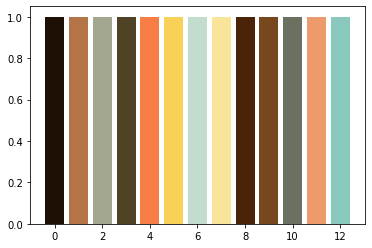

In [316]:
# (we give you the code for this, try to understand it)
# Create and show the LUT and its colors
color_lut = np.uint8(kmeans.cluster_centers_)
plt.bar(np.arange(len(color_lut)), 
         np.ones(len(color_lut)), 
         color=color_lut/255)

In [317]:
# TODO
# Now create a recolored image `test_recolored` containing only indexed colors (ie. in the LUT) using:
# - the original image `poster`, 
# - the mask `poster_mask` of pixels belonging to bubbles (and therefore not to the background)
# - the LUT `color_lut`
# TIP: start by filling your image with white color.



test_recolored = np.ones_like(poster)
test_recolored[poster_mask] = color_lut[label_map]

Text(0.5, 1.0, 'Recolored')

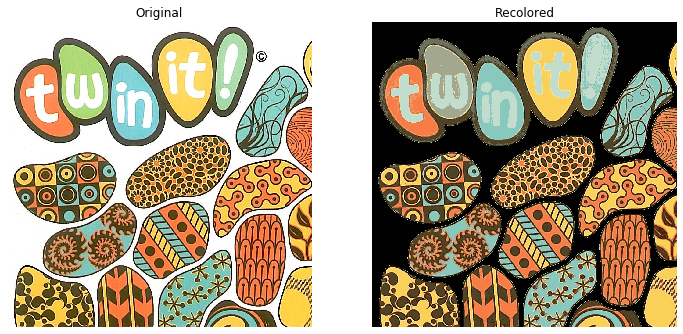

In [318]:
# let us display zoomed portions of the images
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(poster[:1000,:1000])
plt.axis("off")
plt.title("Original")
plt.subplot(1,2,2)
plt.imshow(test_recolored[:1000,:1000])
plt.axis("off")
plt.title("Recolored")

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Does this look correct?**

</div>

(you can write some observations here)

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Save the image and compare its size with the original one. Make sure you use the right color space when saving!**

Tips:

- If saving the RGB image with OpenCV `cv2.imwrite()`, do not forget it expects a BGR image! 
</div>

In [319]:
# TODO save the image and compare the sizes
test_recolored = cv2.cvtColor(test_recolored, cv2.COLOR_RGB2BGR)
cv2.imwrite("/tmp/recolored.png", test_recolored)  # FIXME make sure the exported image is in BGR format here!
# Let us use some notebook magic to check the size of the image
!du -h /tmp/recolored.png
!du -h $PATH_TO_RESOURCES/twin_it_200dpi.png

 22M	/tmp/recolored.png
 46M	twin_it/twin_it_200dpi.png


### 1.4. Load and convert all the bubbles
We can now load and convert all the bubbles. We need to:
1. load them
2. convert them to the same color space as use during training (RGB here)
3. project their colors using the previous method

We will need to ignore the area where all the pixels are black `(0,0,0)`, because they do not belong to the bubble and it may change their value.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**First define a function to compute the mask of a bubble.**

Tip:
- It is a boolean image where $(x,y)$ is `True` as soon as the value of any channel of the original image, at $(x,y)$ is $> 0$.
</div>

In [320]:
# TODO define a function to compute the mask of a bubble
def bubble2mask(bubble):
    return np.any(bubble>0, axis=-1)# FIXME

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Now load all the bubbles and convert them to RGB (or any color space your choosed).**
</div>

In [321]:
# Some Jupyter magic to help you
bubble_files = !ls $PATH_TO_RESOURCES/bubbles_200dpi/b*.png  | sort
bubble_files[:3]

['twin_it/bubbles_200dpi/b001.png',
 'twin_it/bubbles_200dpi/b002.png',
 'twin_it/bubbles_200dpi/b003.png']

In [322]:
# TODO load all the bubbles and convert them to RGB
# `bubbles` is a list of np.array elements (bubble images in RGB format)
bubbles = []

for i in bubble_files:
    # load the base image and its mask.
    a_bubble = cv2.imread(i)
    # let us convert the poster from BGR to RGB for what follows
    # we will work with RGB images
    a_bubble = cv2.cvtColor(a_bubble, cv2.COLOR_BGR2RGB)
    bubbles.append(a_bubble)
    


<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**And reduce the color of all bubbles.**
</div>

In [323]:
# TODO reduce the color of all bubbles
# This is exactly what we did for the full poster, but applied to each bubble AND keeping background as black.
bubbles_quant = []
for bb in bubbles:
    mask = bubble2mask(bb)
    recolored = np.zeros_like(bb)
    label_map = kmeans.predict(bb[mask])
    recolored[mask] = color_lut[label_map]
    bubbles_quant.append(recolored)

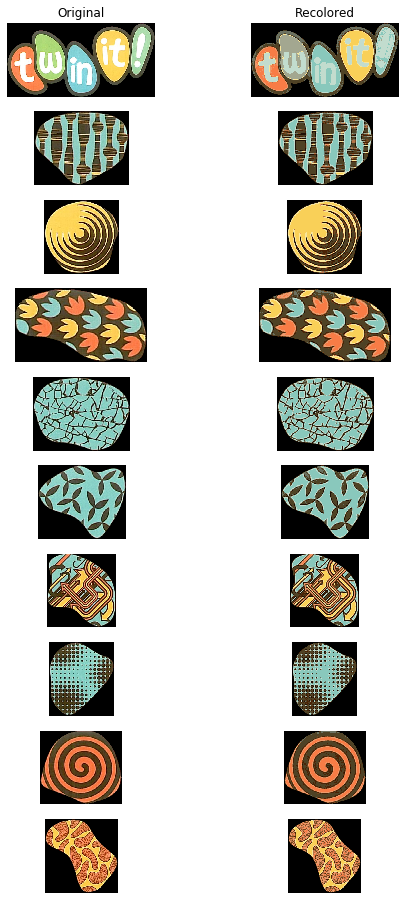

In [324]:
# let us display the images
plt.figure(figsize=(8,16))
for ii in range(10):
    plt.subplot(10,2,1+2*ii)
    plt.imshow(bubbles[ii])
    plt.axis("off")
    if ii == 0:
        plt.title("Original")
    plt.subplot(10,2,2+2*ii)
    plt.imshow(bubbles_quant[ii])
    plt.axis("off")
    if ii == 0:
        plt.title("Recolored")

## 2. Compute the color histograms
To compute the color histogram of a bubble, we do not need to recolorize it, we just need to compute its "label map" to count the number of pixel belonging to each cluster.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the color histogram for each bubble. Use [`np.bincount`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.bincount.html#numpy.bincount) to count the number of number of occurence of each cluster label. Do not forget to normalize the histogram using the number of non-zero values in the mask with [`np.count_nonzero`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.count_nonzero.html).**
</div>

In [325]:
# TODO compute the color histogram for each bubble (number of pixel in each cluster) then normalize it.
# `color_histograms` is a list of np.array, 
# each element being the histogram corresponding to a bubble in `bubbles`.
color_histograms = []

for bb in bubbles:
    mask = bubble2mask(bb)
    label_map = kmeans.predict(bb[mask])
    bb_hist = np.bincount(label_map, minlength=kmeans.n_clusters) / np.count_nonzero(mask)
    color_histograms.append(bb_hist)

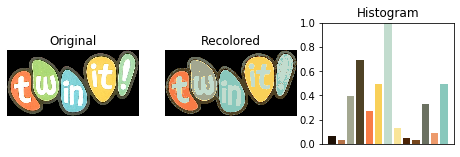

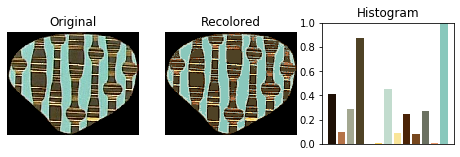

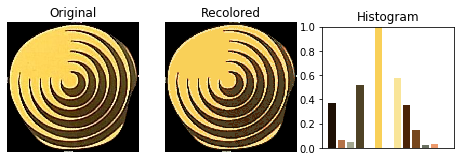

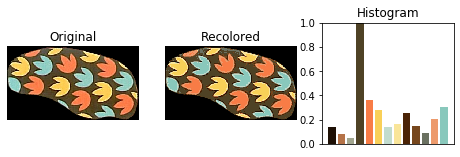

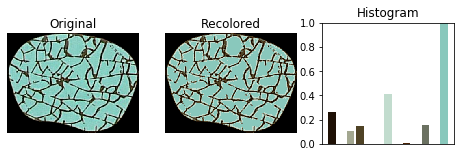

In [326]:
# Show some color histograms with colors!
colors_for_bars = color_lut/255  # matplotlib colors are RGB values scaled to [0,1]
for ii in range(5):
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(bubbles[ii])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(bubbles_quant[ii])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[ii])), 
            color_histograms[ii]/color_histograms[ii].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

## 3. Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Compute the distance matrix between each pair of bubbles. Use an appropriate distance from [`scipy.spatial.distance`](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html).**
</div>

In [331]:
# TODO compute the distance matrix between each pair of bubbles
from scipy.spatial import distance
dist_mat = np.ones((len(bubbles), len(bubbles)))  # distances will be between 0 (closest) and 1 (farthest)
# for... dist_mat[i,j] = ...

from scipy.spatial import distance
for i in range(len(color_histograms)):
    for j in range(len(color_histograms)):
        dist_mat[i,j] = distance.euclidean(color_histograms[i],color_histograms[j]) 
        


Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [332]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Display the best matches for some (all?) bubbles, ie the bubbles which are the closest to a given one. Use `np.argsort` along the appropriate axis to get the indices of the closest elements along each line.**
</div>

In [333]:
# TODO 
# Compute the indices of elements with smallest distance to each bubble (ie. in a matrix row)
# `idx_of_best_matches_per_row` is a 2D np.array: 
# for each row, the columns indicate the indices of the elements in `dist_mat` to sort the row (ascending order)
idx_of_best_matches_per_row = np.argsort(dist_mat, axis = 1)



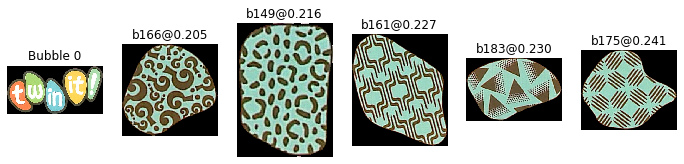

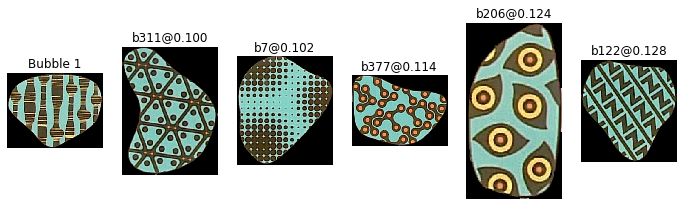

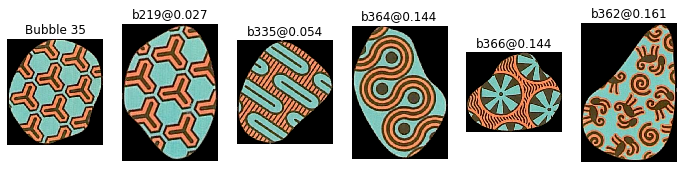

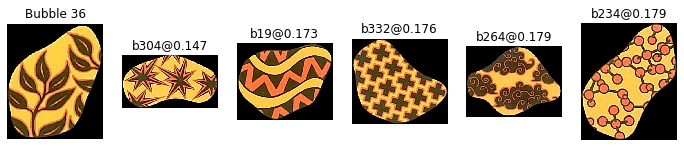

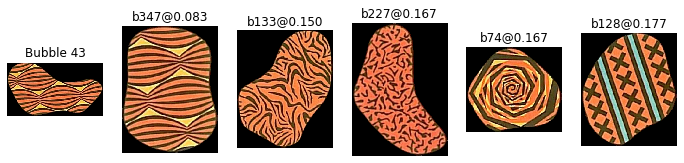

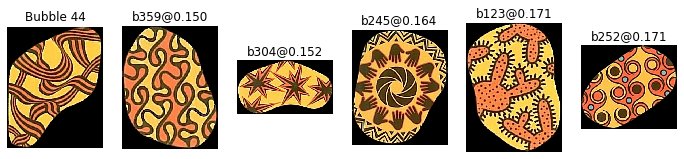

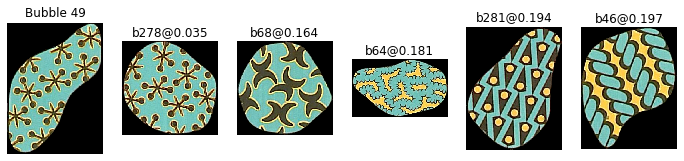

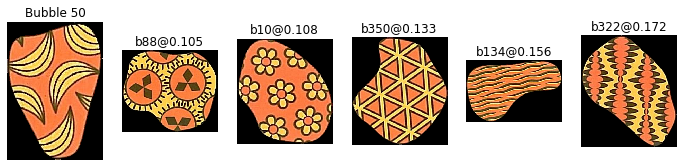

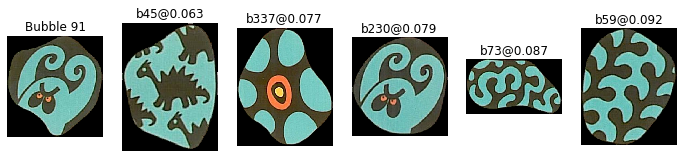

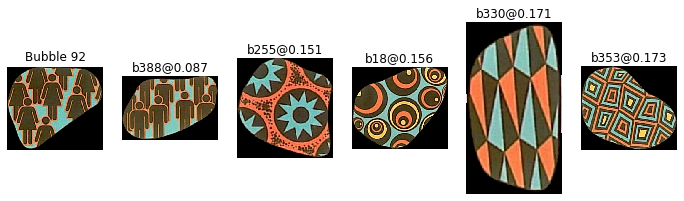

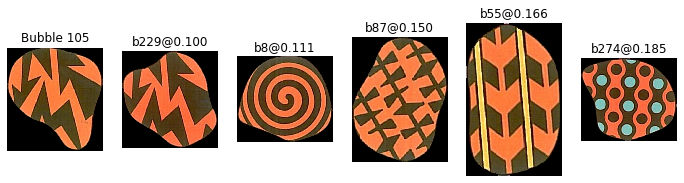

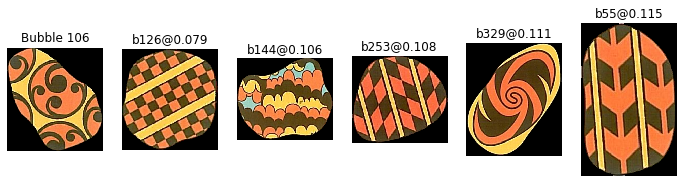

In [334]:
# Display the best matches for some bubbles
max_res = 5
interesting_bubble_ids = [0, 1, 35, 36, 43, 44, 49, 50, 91, 92, 105, 106]

for ii in interesting_bubble_ids:
    plt.figure(figsize=(12,8))
    columns = max_res + 1
    plt.subplot(1, columns, 1)
    plt.imshow(bubbles[ii])
    plt.axis("off"); plt.title("Bubble %d"%(ii,))
    for jj in range(max_res):
        bb_idx = idx_of_best_matches_per_row[ii, jj]  # Read the id of each best match for current bubble
        plt.subplot(1, columns, jj+2)
        plt.imshow(bubbles[bb_idx])
        plt.axis("off"); plt.title("b%d@%.3f" % (bb_idx, dist_mat[ii, bb_idx])) # display bubble id and dist.
    plt.show()

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Write some notes about the advantages and the limitations of the color histogram approach.**
</div>

TODO write some notes here

## 4. Hierarchical clustering and dendrograms
Instead of computing a distance matrix, it is also possible to aggregate the elements starting by the closest one, then iterating. The trick is to be able to compute the distance between a cluster and another cluster, and a simple solution is to average the descriptor of two clusters to form the descriptor of a new parent cluster.

The code below does all this work and produces a dendrogram.

<div style="overflow: auto; border-style: dotted; border-width: 1px; padding: 10px; margin: 10px 0px">
<img alt="work" src='img/work.png' style='float: left; margin-right: 20px'>

**Call the functions (2nd and 3rd cells below) appropriately to generate a beautiful image.**
</div>

In [335]:
# Adapted from https://github.com/jesolem/PCV/blob/master/PCV/clustering/hcluster.py
# licensed under the BSD 2-Clause "Simplified" License
from itertools import combinations

class ClusterNode(object):
    def __init__(self,vec,left,right,distance=0.0,count=1):
        self.left = left
        self.right = right
        self.vec = vec
        self.distance = distance
        self.count = count # only used for weighted average

    def extract_clusters(self,dist):
        """ Extract list of sub-tree clusters from 
            hcluster tree with distance<dist. """
        if self.distance < dist:
            return [self]
        return self.left.extract_clusters(dist) + self.right.extract_clusters(dist)

    def get_cluster_elements(self):
        """    Return ids for elements in a cluster sub-tree. """
        return self.left.get_cluster_elements() + self.right.get_cluster_elements()

    def get_height(self):
        """    Return the height of a node, 
            height is sum of each branch. """
        return self.left.get_height() + self.right.get_height()

    def get_depth(self):
        """    Return the depth of a node, depth is 
            max of each child plus own distance. """
        return max(self.left.get_depth(), self.right.get_depth()) + self.distance

    def draw(self,draw,x,y,s,imlist,im):
        """    Draw nodes recursively with image 
            thumbnails for leaf nodes. """
        h1 = int(self.left.get_height()*60 / 2)
        h2 = int(self.right.get_height()*60 /2)
        top = y-(h1+h2)
        bottom = y+(h1+h2)
        
        # vertical line to children
        cv2.line(draw, (int(top+h1), int(x)) , (int(bottom-h2),int(x)), (0,0,0))
        
        # horizontal lines 
        ll = self.distance*s
        cv2.line(draw, (int(top+h1),int(x)) , (int(top+h1), int(x+ll)), (0,0,0))
        cv2.line(draw, (int(bottom-h2), int(x)) , (int(bottom-h2), int(x+ll)), (0,0,0))
        
        # draw left and right child nodes recursively    
        self.left.draw(draw,x+ll,top+h1,s,imlist,im)
        self.right.draw(draw,x+ll,bottom-h2,s,imlist,im)
    

class ClusterLeafNode(object):
    def __init__(self,vec,id):
        self.vec = vec
        self.id = id

    def extract_clusters(self,dist):
        return [self] 

    def get_cluster_elements(self):
        return [self.id]

    def get_height(self):
        return 1

    def get_depth(self):
        return 0
    
    def draw(self,draw,x,y,s,imlist,im):
        nodeim = cv2.resize(imlist[self.id], (60,60))
        ns = nodeim.shape
        im[int(x):int(x+ns[0]), int(y-ns[1]//2):int(y+ns[1]-ns[1]//2), ...] = nodeim


def hcluster(features, distfcn):
    """
    Cluster the rows of features using hierarchical clustering.
    
    `features`: square matrix of features
    `distfcn`: distance function to compare features (feature x feature -> float)
    """
    
    # cache of distance calculations
    distances = {}
    
    # initialize with each row as a cluster 
    node = [ClusterLeafNode(f,id=i) for i,f in enumerate(features)]
    
    while len(node)>1:
        closest = float('Inf')
        
        # loop through every pair looking for the smallest distance
        for ni,nj in combinations(node,2):
            if (ni,nj) not in distances: 
                distances[ni,nj] = distfcn(ni.vec,nj.vec)
                
            d = distances[ni,nj]
            if d<closest:
                closest = d 
                lowestpair = (ni,nj)
        ni,nj = lowestpair
        
        # average the two clusters
        new_vec = (ni.vec + nj.vec) / 2.0
        
        # create new node
        new_node = ClusterNode(new_vec,left=ni,right=nj,distance=closest)
        node.remove(ni)
        node.remove(nj)
        node.append(new_node)
    
    return node[0]

 
def draw_dendrogram(node, imlist, filename='dendrogram.jpg'):
    """
    Draw a cluster dendrogram and save to a file. 
    
    `node`: result of the `hcluster` function
    `imlist`: list of BGR images for each element
    `filename`: path to output file
    """
    # height and width
    cols = node.get_height()*60
    rows = 1200

    # scale factor for distances to fit image width
    s = float(rows-150)/node.get_depth()
    
    # create image and draw object
    im = np.full((rows,cols, 3), 255, dtype=np.uint8)
    draw = im
    
    # initial line for start of tree 
    cv2.line(draw, (cols//2, 0),(cols//2, 60), (0,0,0))
    
    # draw the nodes recursively
    node.draw(draw,60,(cols/2),s,imlist,im)
    cv2.imwrite(filename, draw)
    print("Wrote '%s'." % filename)

In [336]:
# TODO generate the clusters using the features you computed, and a distance function of your choice

cluster = hcluster(kmeans.cluster_centers_, distance.euclidean)

In [337]:
bubbles_bgr = [cv2.cvtColor(bb, cv2.COLOR_RGB2BGR) for bb in bubbles]
draw_dendrogram(cluster, bubbles_bgr, "my_dendrogram.jpg")

Wrote 'my_dendrogram.jpg'.


# Job done!
Do not forget to submit your notebooks (and maybe a scaled version of your dendrogram)!